Anomaly detection is a technique to identify unusual patterns that do not conform to the expected behaviors, called outliers This project will use Autoencoder-deep unsupervised neural network to detect credit card fraud.

Autoencoder is a data compression algorithm which takes the input and going through a compressed representation and gives the reconstructed output.

In [ ]:
import h2o
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np #linear algebra
import pandas as pd #data processing 
import os
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator



In [ ]:
h2o.init(max_mem_size = 2) #initializing h2o server 
h2o.remove_all()

In [ ]:
#Loading dataset using pandas 
creditData = pd.read_csv('creditcard.csv')
creditData.describe()

In [ ]:
#Exploration 
creditData.shape

In [ ]:
#Checking for null values in the dataset
creditData.isnull().values.any() 

In [ ]:
# Turns python pandas frame into an H2OFrame
creditData_h2o  = h2o.H2OFrame(creditData)
# Let’s plot the Transaction class against the Frequency
labels = ['normal', 'fraud']
classes = pd.value_counts(creditData['Class'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title('Transaction class distribution')
plt.xticks(range(2), labels)
plt.xlabel('Class')
plt.ylabel('Frequency')

In [ ]:
fraud = creditData[creditData.Class ==1]
normal = creditData[creditData.Class ==0]

#Amount Vs Class
f, (ax1, ax2) = plt.subplots(2,1, sharex = True)
f.suptitle('Amount per transaction by class')

ax1.hist(fraud.Amount, bins = 50)
ax1.set_title('Fraud List')

ax2.hist(normal.Amount, bins = 50)
ax2.set_title('Normal')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim((0, 10000))
plt.yscale('log')
plt.show()

In [ ]:
# Time Vs Amount 
f, (ax1, ax2) = plt.subplots(2,1, sharex = True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud List')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in seconds)')
plt.ylabel('Amount')
plt.show()

In [ ]:
#plotting the dataset considering the class
color = {1:'red', 0: 'yellow'}
fraudlist = creditData[creditData.Class ==1]
normal = creditData[creditData.Class == 0]
fig, axes = plt.subplots(1,2)

axes[0].scatter(list(range(1, fraudlist.shape[0] + 1)), fraudlist.Amount, color = 'red')
axes[1].scatter(list(range(1, normal.shape[0] + 1)), normal.Amount, color = 'yellow')
plt.show()

Above figures: Red color denotes fraudlist, yellow denotes normal

#Preparing Data: The Time variable is not giving an impact on the model prediction. This can figure out from data visualization. Before moving on to the training part, we need to figure out which variables are important and which are not. So we can drop the unwanted variables.


In [ ]:
features = creditData_h2o.drop(['Time'], axis = 1)

#Now spliting the data frame as training set and testing set keeping 80% for the training set and rest to the testing set.

In [ ]:
train, test = features.split_frame([0.8])
print(train.shape)
print(test.shape)

Our dataset has a lot of non-fraud transactions. Because of this for the model training, we only send non-fraud transactions. So that the model will learn the pattern of normal transactions.

In [15]:
#converting to pandas dataframe 
train_df = train.as_data_frame()
test_df = test.as_data_frame()

train_df = train_df[train_df['Class'] == 0]

#drop the Class variable 
train_df = train_df.drop(['Class'], axis =1)

Y_test_df = test_df['Class'] #true labels of the testing set 
test_df = test_df.drop(['Class'], axis = 1)

train_df.shape

(227310, 29)

In [17]:
#Model Building 
train_h2o = h2o.H2OFrame(train_df) #converting to h2o frame 
test_h2o = h2o.H2OFrame(test_df)
x = train_h2o.columns

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


When building the model, 4 fully connected hidden layers were chosen with, [14,7,7,14] number of nodes for each layer. First two for the encoder and last two for the decoder.

In [18]:
anomaly_model = H2ODeepLearningEstimator(activation = "Tanh", hidden = [14, 7, 7,14], epochs = 100, standardize = True, stopping_metric = 'MSE', loss = 'automatic', train_samples_per_iteration = 32, shuffle_training_data = True, autoencoder = True, l1 = 10e-5)
anomaly_model.train(x=x, training_frame = train_h2o)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


Model Evaluation: Variable Importance : In H2O there is a special way of analyzing which variables are giving higher impact on the model.


In [20]:
anomaly_model._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,V26,1.000000,1.000000,0.146910
1,V11,0.991404,0.991404,0.145648
2,V24,0.976900,0.976900,0.143517
3,V13,0.976680,0.976680,0.143485
4,V18,0.965242,0.965242,0.141804
5,V19,0.955741,0.955741,0.140408
6,V15,0.922429,0.922429,0.135514
7,V4,0.005148,0.005148,0.000756
8,V14,0.001652,0.001652,0.000243
9,V25,0.001608,0.001608,0.000236


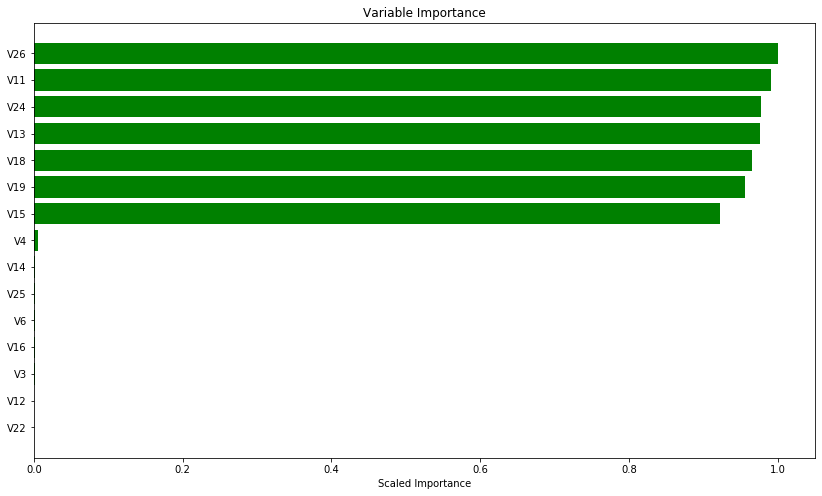

In [25]:
#Visualization: plot the variable importance 
rcParams['figure.figsize'] = 14, 8

#plot.rcdefaults
fig, ax = plt.subplots()

variables = anomaly_model._model_json['output']['variable_importances']['variable']
var = variables[0:15]
y_pos = np.arange(len(var))

scaled_importance = anomaly_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:15]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()


Text(0.5, 0, 'epoch')

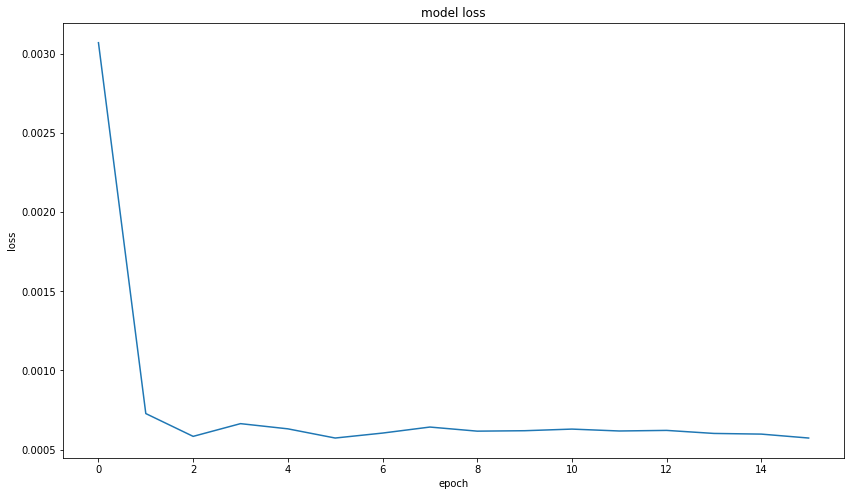

In [28]:
# plotting the loss
scoring_history = anomaly_model.score_history()
%matplotlib inline
rcParams['figure.figsize'] = 14, 8
plt.plot(scoring_history['training_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

The testing set has both normal and fraud transactions in it. The Autoencoder will learn to identify the pattern of the input data. If an anomalous test point does not match the learned pattern, the autoencoder will likely have a high error rate in reconstructing this data, indicating anomalous data. So that we can identify the anomalies of the data. To calculate the error, it uses Mean Squared Error(MSE)

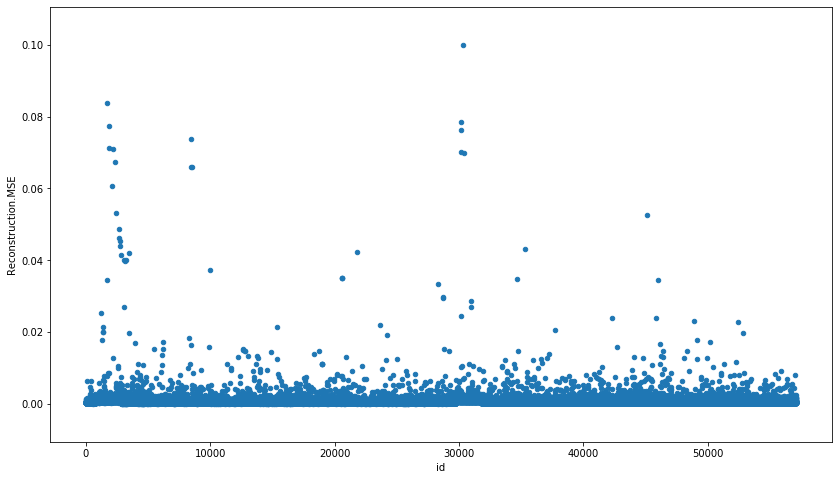

In [29]:
## anomaly is a H2O function which calculates the error for the dataset
test_rec_error = anomaly_model.anomaly(test_h2o)

#converting the pandas dataframe
test_rec_error_df = test_rec_error.as_data_frame()

#plotting the testing dataset against the error 
test_rec_error_df['id']=test_rec_error_df.index
rcParams['figure.figsize'] = 14, 8
test_rec_error_df.plot(kind = "scatter", x = 'id', y = "Reconstruction.MSE")
plt.show()

In [30]:
#predicting the class for the testing dataset (PCA-Principal component Analysis)
predictions = anomaly_model.predict(test_h2o)

error_df = pd.DataFrame({'reconstruction_error' : test_rec_error_df['Reconstruction.MSE'], 'true_class': Y_test_df})

error_df.describe()

deeplearning prediction progress: |███████████████████████████████████████| 100%


,reconstruction_error,true_class
count,57096.000000,57096.000000
mean,0.000621,0.001594
std,0.001657,0.039891
min,0.000039,0.000000
25%,0.000231,0.000000
50%,0.000382,0.000000
75%,0.000685,0.000000
max,0.099956,1.000000


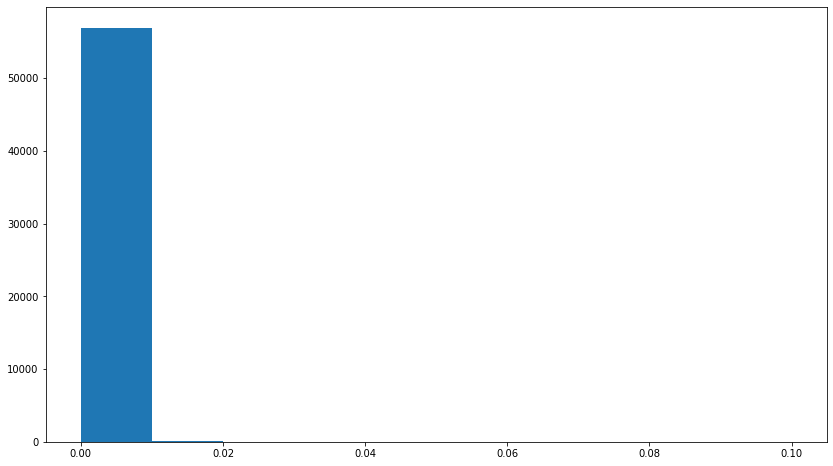

In [31]:
#Reconstruction error for the normal transactions in the testing dataset
fig = plt.figure()
ax = fig.add_subplot(111)
rcParams['figure.figsize'] = 14, 8
normal_error_df = error_df[(error_df['true_class'] ==0) & (error_df['reconstruction_error'] < 10)]
_=ax.hist(normal_error_df.reconstruction_error.values, bins =10)

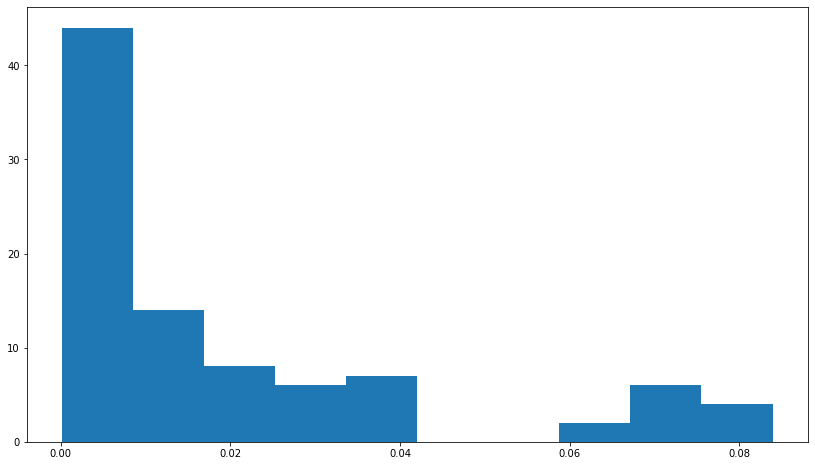

In [33]:
#reconstruction error for the fraud transactions in the testing dataset
fig = plt.figure()
ax = fig.add_subplot(111)
rcParams['figure.figsize'] = 14, 8
fraud_error_df = error_df[error_df['true_class'] ==1]
_=ax.hist(fraud_error_df.reconstruction_error.values, bins =10)


ROC Curve: Receiver Operating Characteristic Curves. ROC is a plot of signal (True Positive Rate) against noise (False Positive Rate). AUC =area under the curve


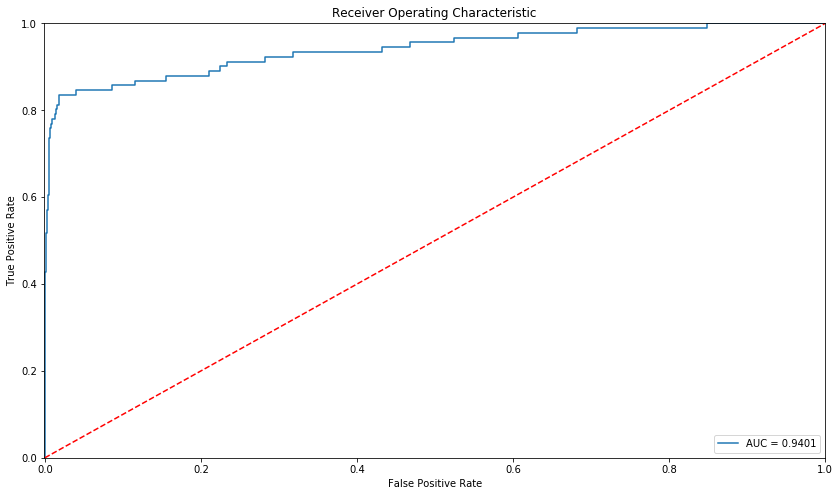

In [36]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
#false positive result, true positive result
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();


The accuracy is 0.9401

Precision & Recall

Since the data is highly imbalanced, it cannot be measured only by using accuracy. Precision vs Recall was chosen as the matrix for the classification task.

Precision: Measuring the relevancy of obtained results.
[ True positives / (True positives + False positives)]
Recall: Measuring how many relevant results are returned.
[ True positives / (True positives + False negatives)]
True Positives — Number of actual frauds predicted as frauds.
False Positives — Number of non-frauds predicted as frauds.
False Negatives — Number of frauds predicted as non-frauds.

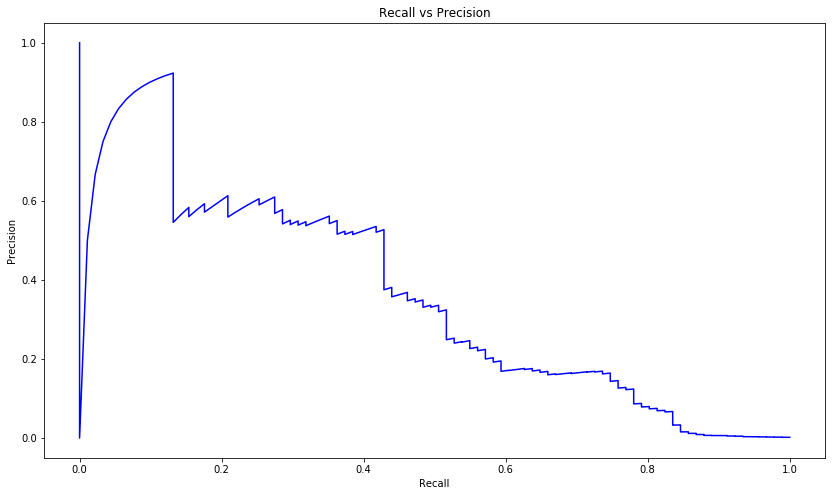

In [53]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

We need to find a better threshold that can separate the anomalies from normal. This can be done by calculating the intersection of the Precision/Recall vs Threshold graph.

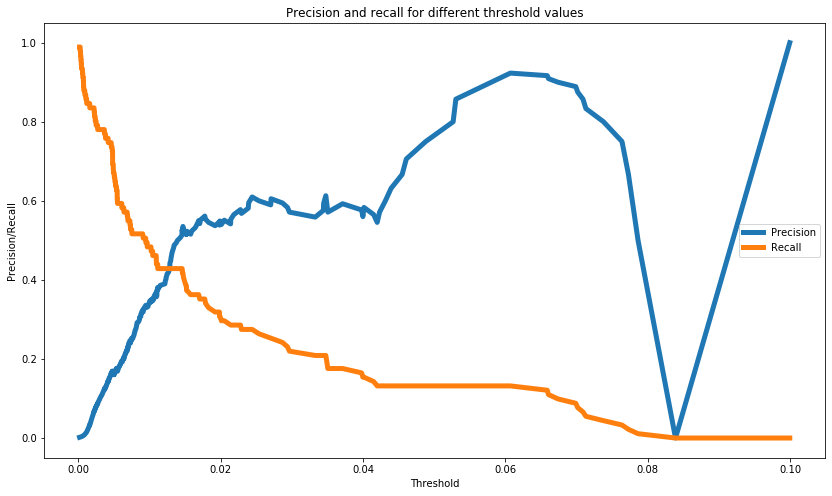

In [45]:
plt.plot(th, precision[1:], label="Precision",linewidth=5)
plt.plot(th, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

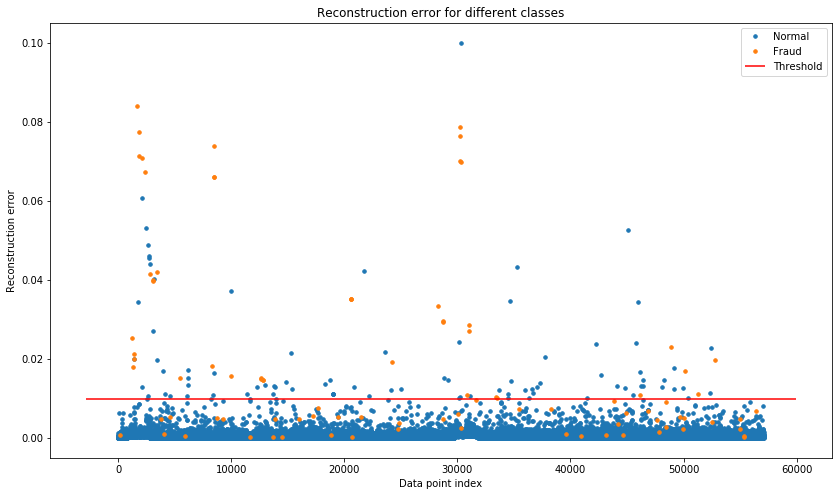

In [46]:
# plot the testing set with the threshold
threshold = 0.01
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

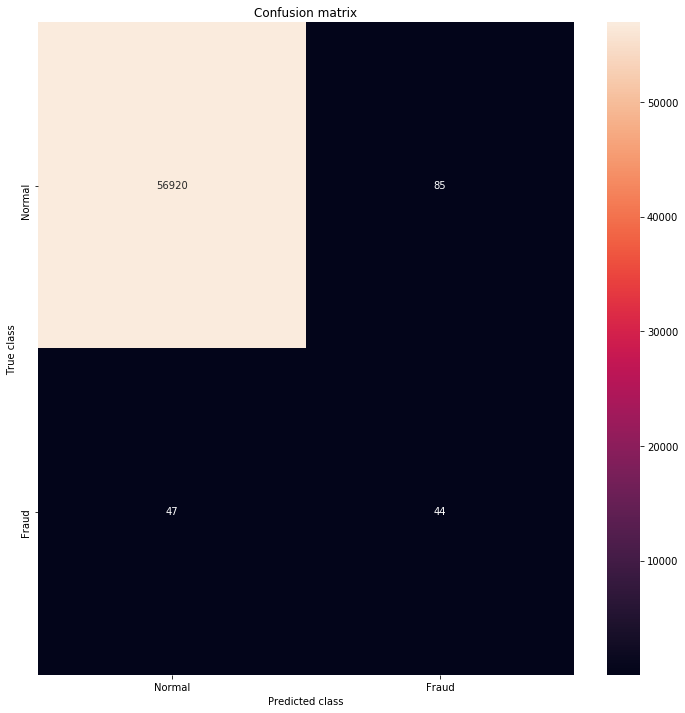

In [51]:
#Confusion Matrix
import seaborn as sns
LABELS = ['Normal', 'Fraud']
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [52]:
#Classification Report 
csr = classification_report(error_df.true_class, y_pred)
print(csr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57005
           1       0.34      0.48      0.40        91

    accuracy                           1.00     57096
   macro avg       0.67      0.74      0.70     57096
weighted avg       1.00      1.00      1.00     57096



Conclusion: 
Our model is catching most of the fraudulent data. In Autoencoders, it gives a good accuracy. But if we look into Precision and Recall of the dataset, it is not performing enough.
There are other anomaly detection methods that perform well in highly imbalanced datasets.
